# Auditing Bias

### Jiffy Lesica

Goals:
1. Train a machine learning algorithm to predict whether someone is currently employed, based on their other attributes not including gender, and
2. Perform a bias audit of our algorithm to determine whether it displays gender bias.

In this blog post, I trained a machine learning classifier on PUMS data from the state of Connecticut to predict an individual’s employment status based on demographic features. After preparing the data with the folktables library, I experimented with a various classifier models, ultimately deciding on a Random Forest model whose performance I evaluated using metrics like accuracy, Positive Prediction Value, and False Positive/Negative Rates. I then conducted a bias audit by examining false positive rates (FPR), false negative rates (FNR), and positive predictive value (PPV) across the gender groups available in the data - Male and Female. I then plotted feasible FNRs & FPRs to visualize the relationship of error rates between groups, and understand how much one group’s error rate would have to change to match the others. Our results showed notable differences in error rates and PPVs between groups, highlighting areas where the model may inadvertently misclassify women more frequently.

In [164]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "CT"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000191,1,1,302,1,9,1013097,40,90,...,82,39,38,81,0,38,0,0,36,34
1,P,2018GQ0000285,1,1,101,1,9,1013097,70,18,...,69,134,7,70,6,68,141,68,132,145
2,P,2018GQ0000328,1,1,1101,1,9,1013097,17,54,...,37,35,16,16,0,17,18,19,18,16
3,P,2018GQ0000360,1,1,905,1,9,1013097,47,18,...,46,48,4,90,87,84,90,3,47,48
4,P,2018GQ0000428,1,1,903,1,9,1013097,35,96,...,32,35,36,71,36,3,37,2,2,35


In [114]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,90,16.0,5,17,1,NaN,1,1.0,4.0,1,1,2,2,1.0,2,1,6.0
1,18,16.0,5,17,2,NaN,1,1.0,4.0,2,1,2,2,2.0,2,1,6.0
2,54,17.0,5,17,1,NaN,1,3.0,4.0,1,1,2,2,1.0,1,2,6.0
3,18,19.0,5,17,2,NaN,3,3.0,4.0,2,1,2,2,2.0,1,1,1.0
4,96,16.0,2,16,1,NaN,1,3.0,4.0,4,1,2,2,1.0,2,1,6.0


## My Version

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [124]:
features_to_use1 = [f for f in possible_features if f not in ["ESR", "SEX"]]

In [125]:
EmploymentProblemSex = BasicProblem(
    features=features_to_use1,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='SEX',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblemSex.df_to_numpy(acs_data)

In [126]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

*Convert Folktables data back to Pandas DataFrame for ease of descriptive analysis*

In [127]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use1)
df["group"] = group_train
df["label"] = y_train

### 1. How many individuals are in the data?

In [128]:
print(f"There are {df.shape[0]} individuals in the data for the state of CT")

There are 29029 individuals in the data for the state of CT


### 2. How Many Individuals Have a Target Label == 1 (i.e. How Many Individuals are Employed)?

In [129]:
print(f"Of the {df.shape[0]} in the data set, {(df['label'].mean() * 100):.2f}% - or {df['label'].sum()} individuals - are employed")

Of the 29029 in the data set, 48.43% - or 14060 individuals - are employed


### 3. Of the Employed Individuals, How Many are Male (1) and How Many are Female (2)?

In [130]:
employed_by_group = df.groupby("group")["label"].sum()
print(f"Of the 14060 employed individuals, {employed_by_group.iloc[0]} are male and {employed_by_group.iloc[1]} are female")

Of the 14060 employed individuals, 7169 are male and 6891 are female


### 4. In Each Group, What Proportion of Individuals Have Target Label Equal to 1 (i.e. Are Employed)?

In [131]:
proportion_employed_by_group = df.groupby("group")["label"].mean()
print(f"According to the Data,{proportion_employed_by_group.iloc[0]*100: .2f}% of male individuals are employed and{proportion_employed_by_group.iloc[1]*100: .2f}% female individuals are employed")

According to the Data, 51.17% of male individuals are employed and 45.88% female individuals are employed


### 5. Intersectional Trends

In [ ]:
# Since RAC1P Has Values > 2, we must filter to only 1.0 and 2.0
df_filtered = df[(df["RAC1P"] == 1.0) | (df["RAC1P"] == 2.0)].copy()
# Now, we convert RAC1P values to ints to match type
df_filtered["RAC1P"] = df_filtered["RAC1P"].astype(int)
# Since I want to use categorical labels, and not just numbered labels, we use Pandas map function on a series
# https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html
df_filtered["group"] = df_filtered["group"].map({1 : "Male", 2 : "Female"})
df_filtered["RAC1P"] = df_filtered["RAC1P"].map({1 : "White", 2 : "Black"})
proportion_employed_by_group = df_filtered.groupby(["group", "RAC1P"])["label"].mean()

group   RAC1P
Female  Black    0.466667
        White    0.464758
Male    Black    0.371805
        White    0.535252
Name: label, dtype: float64

Text(0.5, 1.0, 'Intersectional Trends')

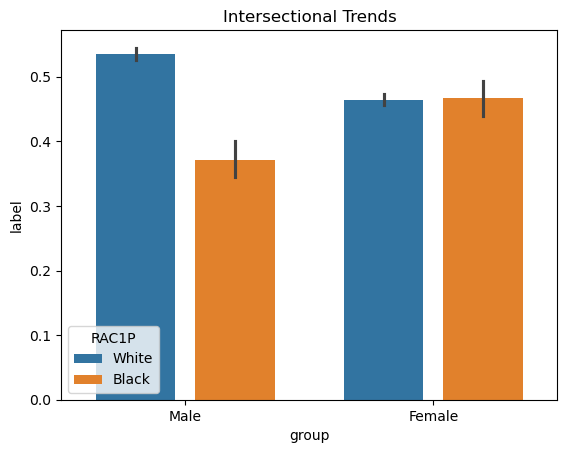

In [168]:
import seaborn as sns
from matplotlib import pyplot as plt

# Using seaborn barplot uses mean as default, which represents the proportional insights we are looking for
sns.barplot(df_filtered, x = "group", y = "label", hue = "RAC1P", width=.8, gap=.2)
plt.title("Intersectional Trends")

*Training my model with different classifiers*

In [134]:
# Include alternative classifiers from sklearn
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Logistic Regression

In [135]:
# Logistic Regression Classifier (playing with polynomial features)
# Discovered we can ass PolynomialFeatures to pipeline!
from sklearn.preprocessing import PolynomialFeatures
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
model_sex_LR = make_pipeline(PolynomialFeatures(degree = 2), StandardScaler(), LogisticRegression(max_iter=1000))
model_sex_LR.fit(X_train.copy(), y_train)

y_hat_LR = model_sex_LR.predict(X_test)

# Calculate Overall Values
TP_LR = ((y_hat_LR == 1) & (y_test == 1)).sum()
FP_LR = ((y_hat_LR == 1) & (y_test == 0)).sum()
TN_LR = ((y_hat_LR == 0) & (y_test == 0)).sum()
FN_LR = ((y_hat_LR == 0) & (y_test == 1)).sum()

PPV_LR = TP_LR / (y_hat_LR == 1).sum()
FPR_LR = FP_LR / (TP_LR + FP_LR)
FNR_LR = FN_LR / (TP_LR + FN_LR)

print(f"Accuracy for Logistic Regression:{((y_hat_LR == y_test).mean())*100: .2f}%")
print(f"PPV for Logistic Regression:{PPV_LR*100: .2f}%")
print(f"Overall FPR for LR:{FPR_LR*100: .2f}%")
print(f"Overall FNR for LR:{FNR_LR*100: .2f}%")

Accuracy for Logistic Regression: 82.57%
PPV for Logistic Regression: 79.65%
Overall FPR for LR: 20.35%
Overall FNR for LR: 12.74%


In [136]:
# Breaking down by subgroups is much easier if we use a Dataframe
df_test_LR = pd.DataFrame(X_test, columns = features_to_use1)
df_test_LR["group"] = group_test
df_test_LR["label"] = y_test
df_test_LR["predicted_value"] = y_hat_LR
df_test_LR["correct_prediction"] = df_test_LR["predicted_value"] == df_test_LR["label"]

# Calculate correct prediction by group
df_test_LR["correct_prediction"] = df_test_LR["predicted_value"] == df_test_LR["label"]
print(f"\nAccuracy By Group: \n \n {df_test_LR.groupby(['group'])['correct_prediction'].mean()*100}")

# Calculate true positives and false positives by group
df_test_LR["true_positive"] = (df_test_LR["predicted_value"] == 1) & (df_test_LR["label"] == 1)
df_test_LR["false_positive"] = (df_test_LR["predicted_value"] == 1) & (df_test_LR["label"] == 0)

# Calculate PPV by group
TP_per_group_LR = df_test_LR.groupby("group")["true_positive"].sum()
FP_per_group_LR = df_test_LR.groupby("group")["false_positive"].sum()
PPV_per_group = TP_per_group_LR / (TP_per_group_LR + FP_per_group_LR)
print(f"\nPPV By Group: \n {PPV_per_group * 100}")

# Calculate false positives by group
df_test_LR["false_positive"] = (df_test_LR["predicted_value"] == 1) & (df_test_LR["label"] == 0) 
print(f"\nFPR By Group: \n \n {df_test_LR.groupby(['group'])['false_positive'].mean()*100}")

# Calculate false negatives by group
df_test_LR["false_negative"] = (df_test_LR["predicted_value"] == 0) & (df_test_LR["label"] == 1) 
print(f"\nFNR By Group: \n \n {df_test_LR.groupby(['group'])['false_negative'].mean()*100}")

# Compute for statistical parity by group

# Total individuals per group
per_group_total_LR = df_test_LR.groupby("group")["predicted_value"].count()

# Total predicted positives per group
predicted_positives_per_group_LR = df_test_LR.groupby("group")["predicted_value"].sum()

# Calculate acceptance rate
statistical_parity_by_group_LR = (predicted_positives_per_group_LR / per_group_total_LR) * 100
print(f"\nAcceptance Rate (Employment) By Group: \n {statistical_parity_by_group_LR}%")




Accuracy By Group: 
 
 group
1    84.209040
2    81.011296
Name: correct_prediction, dtype: float64

PPV By Group: 
 group
1    83.887734
2    75.639764
dtype: float64

FPR By Group: 
 
 group
1     8.757062
2    13.313609
Name: false_positive, dtype: float64

FNR By Group: 
 
 group
1    7.033898
2    5.675094
Name: false_negative, dtype: float64

Acceptance Rate (Employment) By Group: 
 group
1    54.350282
2    54.653039
Name: predicted_value, dtype: float64%


#### Discussion:

By implementing the PolynomialFeatures preprocessing function/module, I was able to add polynomial feature adjustments directly into the model pipeline. By calculating all polynomial combinations of my features with a degree of 2, I achieved my best accuracy of 82.57%.

## SVC

In [137]:
# SVC Classifier
model_sex_SVC = make_pipeline(StandardScaler(), SVC(C = 3.0))
model_sex_SVC.fit(X_train, y_train)

y_hat_SVC = model_sex_SVC.predict(X_test)

# Calculate Overall Values
TP_SVC = ((y_hat_SVC == 1) & (y_test == 1)).sum()
FP_SVC = ((y_hat_SVC == 1) & (y_test == 0)).sum()
TN_SVC = ((y_hat_SVC == 0) & (y_test == 0)).sum()
FN_SVC = ((y_hat_SVC == 0) & (y_test == 1)).sum()

PPV_SVC = TP_SVC / (y_hat_SVC == 1).sum()
FPR_SVC = FP_SVC / (TP_SVC + FP_SVC)
FNR_SVC = FN_SVC / (TP_SVC + FN_SVC)

print(f"Accuracy for SVC:{((y_hat_SVC == y_test).mean())*100: .2f}%")
print(f"PPV for SVC:{PPV_SVC*100: .2f}%")
print(f"Overall FPR for SVC:{FPR_SVC*100: .2f}%")
print(f"Overall FNR for SVC:{FNR_SVC*100: .2f}%")

Accuracy for SVC: 82.41%
PPV for SVC: 78.79%
Overall FPR for SVC: 21.21%
Overall FNR for SVC: 11.55%


In [138]:
# Breaking down by subgroups is much easier if we use a Dataframe
df_test_SVC = pd.DataFrame(X_test, columns = features_to_use1)
df_test_SVC["group"] = group_test
df_test_SVC["label"] = y_test
df_test_SVC["predicted_value"] = y_hat_SVC
df_test_SVC["correct_prediction"] = df_test_SVC["predicted_value"] == df_test_SVC["label"]

# Calculate correct prediction by group
df_test_SVC["correct_prediction"] = df_test_SVC["predicted_value"] == df_test_SVC["label"]
print(f"\nAccuracy By Group: \n {df_test_SVC.groupby(['group'])['correct_prediction'].mean()*100}")

# Calculate true positives and false positives by group
df_test_SVC["true_positive"] = (df_test_SVC["predicted_value"] == 1) & (df_test_SVC["label"] == 1)
df_test_SVC["false_positive"] = (df_test_SVC["predicted_value"] == 1) & (df_test_SVC["label"] == 0)

# Calculate PPV by group
TP_per_group_SVC = df_test_SVC.groupby("group")["true_positive"].sum()
FP_per_group_SVC = df_test_SVC.groupby("group")["false_positive"].sum()
PPV_per_group = TP_per_group_SVC / (TP_per_group_SVC + FP_per_group_SVC)
print(f"\nPPV By Group: \n {PPV_per_group * 100}")

# Calculate false positives by group
df_test_SVC["false_positive"] = (df_test_SVC["predicted_value"] == 1) & (df_test_SVC["label"] == 0) 
print(f"\nFPR By Group: \n {df_test_SVC.groupby(['group'])['false_positive'].mean()*100}")

# Calculate false negatives by group
df_test_SVC["false_negative"] = (df_test_SVC["predicted_value"] == 0) & (df_test_SVC["label"] == 1) 
print(f"\nFNR By Group: \n {df_test_SVC.groupby(['group'])['false_negative'].mean()*100}")

# Compute for statistical parity by group

# Total individuals per group
per_group_total_SVC = df_test_SVC.groupby("group")["predicted_value"].count()

# Total predicted positives per group
predicted_positives_per_group_SVC = df_test_SVC.groupby("group")["predicted_value"].sum()

# Calculate acceptance rate
statistical_parity_by_group_SVC = (predicted_positives_per_group_SVC / per_group_total_SVC) * 100
print(f"\nAcceptance Rate (Employment) By Group: \n {statistical_parity_by_group_SVC}")



Accuracy By Group: 
 group
1    84.406780
2    80.500269
Name: correct_prediction, dtype: float64

PPV By Group: 
 group
1    83.324860
2    74.508864
dtype: float64

FPR By Group: 
 group
1     9.265537
2    14.308768
Name: false_positive, dtype: float64

FNR By Group: 
 group
1    6.327684
2    5.190963
Name: false_negative, dtype: float64

Acceptance Rate (Employment) By Group: 
 group
1    55.564972
2    56.132329
Name: predicted_value, dtype: float64


#### Discussion:

From what I could find on sklearn and online (this Medium article: https://medium.com/@myselfaman12345/c-and-gamma-in-svm-e6cee48626be) C - to put it generally - indicates *how much* we want to avoid misclassification on our training data. A low C value leads to low training error, and high C allows for more error on training data. However, minimizing C - and therefore training classification error - too far seems to lead to over fitting. As I dropped the C value below 1.0 (the default sklearn value) I found my classification accuracy begin to drop. Setting it too high led to the same effect. It seems that the "optimal" C value is context-dependent. Interestingly, my  accuracy was very similary at a C value of 0.8 (82.35%) and 3.0 (82.41%). The default C value of 1.0 resulted in an 83.32% accuracy.

*Extract predicitions on all test sets modeled with each classifier*

## Decision Tree

In [139]:
# Decision Tree Classifier
model_sex_DT = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=12, min_samples_split=8))
model_sex_DT.fit(X_train, y_train)

y_hat_DT = model_sex_DT.predict(X_test)

# Calculate Overall Values
TP_DT = ((y_hat_DT == 1) & (y_test == 1)).sum()
FP_DT = ((y_hat_DT == 1) & (y_test == 0)).sum()
TN_DT = ((y_hat_DT == 0) & (y_test == 0)).sum()
FN_DT = ((y_hat_DT == 0) & (y_test == 1)).sum()

PPV_DT = TP_DT / (y_hat_DT == 1).sum()
FPR_DT = FP_DT / (TP_DT + FP_DT)
FNR_DT = FN_DT / (TP_DT + FN_DT)

print(f"Accuracy for Decision Tree:{((y_hat_DT == y_test).mean())*100: .2f}%")
# No Parameters: 77.28%, With Parameters: 83.12% 
print(f"PPV for Decision Tree:{PPV_DT*100: .2f}%")
print(f"Overall FPR for Decision Tree:{FPR_DT*100: .2f}%")
print(f"Overall FNR for Decision Tree:{FNR_DT*100: .2f}%")

Accuracy for Decision Tree: 83.11%
PPV for Decision Tree: 80.41%
Overall FPR for Decision Tree: 19.59%
Overall FNR for Decision Tree: 12.68%


In [140]:
# Breaking down by subgroups is much easier if we use a Dataframe
df_test_DT = pd.DataFrame(X_test, columns = features_to_use1)
df_test_DT["group"] = group_test
df_test_DT["label"] = y_test
df_test_DT["predicted_value"] = y_hat_DT
df_test_DT["correct_prediction"] = df_test_DT["predicted_value"] == df_test_DT["label"]

# Calculate correct prediction by group
df_test_DT["correct_prediction"] = df_test_DT["predicted_value"] == df_test_DT["label"]
print(f"\nAccuracy By Group: \n {df_test_DT.groupby(['group'])['correct_prediction'].mean()*100}")

# Calculate true positives and false positives by group
df_test_DT["true_positive"] = (df_test_DT["predicted_value"] == 1) & (df_test_DT["label"] == 1)
df_test_DT["false_positive"] = (df_test_DT["predicted_value"] == 1) & (df_test_DT["label"] == 0)

# Calculate PPV by group
TP_per_group_DT = df_test_DT.groupby("group")["true_positive"].sum()
FP_per_group_DT = df_test_DT.groupby("group")["false_positive"].sum()
PPV_per_group = TP_per_group_DT / (TP_per_group_DT + FP_per_group_DT)
print(f"\nPPV By Group: \n {PPV_per_group * 100}")

# Calculate false positives by group
df_test_DT["false_positive"] = (df_test_DT["predicted_value"] == 1) & (df_test_DT["label"] == 0) 
print(f"\nFPR By Group: \n {df_test_DT.groupby(['group'])['false_positive'].mean()*100}")

# Calculate false negatives by group
df_test_DT["false_negative"] = (df_test_DT["predicted_value"] == 0) & (df_test_DT["label"] == 1) 
print(f"\nFNR By Group: \n {df_test_DT.groupby(['group'])['false_negative'].mean()*100}")

# Compute for statistical parity by group

# Total individuals per group
per_group_total_DT = df_test_DT.groupby("group")["predicted_value"].count()

# Total predicted positives per group
predicted_positives_per_group_DT = df_test_DT.groupby("group")["predicted_value"].sum()

# Calculate acceptance rate
statistical_parity_by_group_DT = (predicted_positives_per_group_DT / per_group_total_DT) * 100
print(f"\nAcceptance Rate (Employment) By Group: \n {statistical_parity_by_group_DT}")


Accuracy By Group: 
 group
1    85.084746
2    81.226466
Name: correct_prediction, dtype: float64

PPV By Group: 
 group
1    85.039370
2    76.041667
dtype: float64

FPR By Group: 
 group
1     8.050847
2    12.990855
Name: false_positive, dtype: float64

FNR By Group: 
 group
1    6.864407
2    5.782679
Name: false_negative, dtype: float64

Acceptance Rate (Employment) By Group: 
 group
1    53.813559
2    54.222700
Name: predicted_value, dtype: float64


#### Discussion:

The Decision Tree Classifier achieved it's highest accuracy of 83.12% with a max-depth of 12 and a min_samples_split - the minimum number of samples required to split an internal node - of 8. This classifier also ran the fasted of all the classifiers tested with parameters. 

## Random Forest

In [141]:
# Random Forest Classifier
model_sex_RF = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=400, max_depth=16))
model_sex_RF.fit(X_train, y_train)

y_hat_RF = model_sex_RF.predict(X_test)

# Calculate Overall Values
TP_RF = ((y_hat_RF == 1) & (y_test == 1)).sum()
FP_RF = ((y_hat_RF == 1) & (y_test == 0)).sum()
TN_RF = ((y_hat_RF == 0) & (y_test == 0)).sum()
FN_RF = ((y_hat_RF == 0) & (y_test == 1)).sum()

PPV_RF = TP_RF / (y_hat_RF == 1).sum()
FPR_RF = FP_RF / (TP_RF + FP_RF)
FNR_RF = FN_RF / (TP_RF + FN_RF)

print(f"Accuracy for Random Forest:{((y_hat_RF == y_test).mean())*100: .2f}%")
# Without Parameters: 80.92%, With Parameters: 83.74%
print(f"Overall PPV for Random Forest:{PPV_RF*100: .2f}%")
print(f"Overall FPR for Random Forest:{FPR_RF*100: .2f}%")
print(f"Overall FNR for Random Forest:{FNR_RF*100: .2f}%")



Accuracy for Random Forest: 83.70%
Overall PPV for Random Forest: 80.81%
Overall FPR for Random Forest: 19.19%
Overall FNR for Random Forest: 11.82%


In [142]:
# Breaking down by subgroups is much easier if we use a Dataframe
df_test_RF = pd.DataFrame(X_test, columns = features_to_use1)
df_test_RF["group"] = group_test
df_test_RF["label"] = y_test
df_test_RF["predicted_value"] = y_hat_RF
df_test_RF["correct_prediction"] = df_test_RF["predicted_value"] == df_test_RF["label"]

# Calculate correct prediction by group
df_test_RF["correct_prediction"] = df_test_RF["predicted_value"] == df_test_RF["label"]
print(f"\nAccuracy By Group: \n \n {df_test_RF.groupby(['group'])['correct_prediction'].mean()*100}")

# Calculate true positives and false positives by group
df_test_RF["true_positive"] = (df_test_RF["predicted_value"] == 1) & (df_test_RF["label"] == 1)
df_test_RF["false_positive"] = (df_test_RF["predicted_value"] == 1) & (df_test_RF["label"] == 0)

# Calculate PPV by group
TP_per_group_RF = df_test_RF.groupby("group")["true_positive"].sum()
FP_per_group_RF = df_test_RF.groupby("group")["false_positive"].sum()
PPV_per_group = TP_per_group_RF / (TP_per_group_RF + FP_per_group_RF)
print(f"\nPPV By Group: \n {PPV_per_group * 100}")

# Calculate false positives by group
df_test_RF["false_positive"] = (df_test_RF["predicted_value"] == 1) & (df_test_RF["label"] == 0) 
print(f"\nFPR By Group: \n \n {df_test_RF.groupby(['group'])['false_positive'].mean()*100}")

# Calculate false negatives by group
df_test_RF["false_negative"] = (df_test_RF["predicted_value"] == 0) & (df_test_RF["label"] == 1) 
print(f"\nFNR By Group: \n \n {df_test_RF.groupby(['group'])['false_negative'].mean()*100}")

# Compute for statistical parity by group

# Total individuals per group
per_group_total_RF = df_test_RF.groupby("group")["predicted_value"].count()

# Total predicted positives per group
predicted_positives_per_group_RF = df_test_RF.groupby("group")["predicted_value"].sum()

# Calculate acceptance rate
statistical_parity_by_group_RF = (predicted_positives_per_group_RF / per_group_total_RF) * 100
print(f"\nAcceptance Rate (Employment) By Group: \n {statistical_parity_by_group_RF}")



Accuracy By Group: 
 
 group
1    85.706215
2    81.791286
Name: correct_prediction, dtype: float64

PPV By Group: 
 group
1    85.356957
2    76.496784
dtype: float64

FPR By Group: 
 
 group
1     7.937853
2    12.775686
Name: false_positive, dtype: float64

FNR By Group: 
 
 group
1    6.355932
2    5.433029
Name: false_negative, dtype: float64

Acceptance Rate (Employment) By Group: 
 group
1    54.209040
2    54.357181
Name: predicted_value, dtype: float64


#### Discussion:

While increasing max_depth to 16 itself led to the largest increase in classifier accuracy, adding more estimators - n_estimators set to 400 - to the model led to a further increase in accuracy from 83.55% to 83.74%. Random Forest achieved the highest prediction accuracy of all models tested. 

## Bias Measures:

1. A model is consider well calibrated if it reflects the same likelihood of positive prediction irrespective an individuals' group membership. In other words, the model should be free from predictive bias. It appears that none of the models are well-calibrated as across all of them, the positive prediction rate of male employment is several percentage points higher than female employment. More specifically, the PPV ranges from anywhere between ~8%-9% across all of the models.

2. Across the board, again, the models do not satisfy error rate balance. The False Positive Rate (FPR) is higher for females across all four, whereas the False Negative Rate (FNR) is higher for males across all four models. Even further, the margin of difference between groups for FPR is much greater than that for FNR across all Models. The FPR difference between groups is at its lowest ~4.56% in our LR model, whereas the largest difference in FNRs is ~1.36%, also found in our LR model.

3. The best performing fairness metric across our models is statistical parity, with no models differing more than .7% in acceptance rate (i.e. employment prediction) between male and females. 

## Plotting Feasible FNR and FPR Rates

*Using Random Forest Model because it had the best accuracy per group*

0.8535695674830641
0.7649678377041069


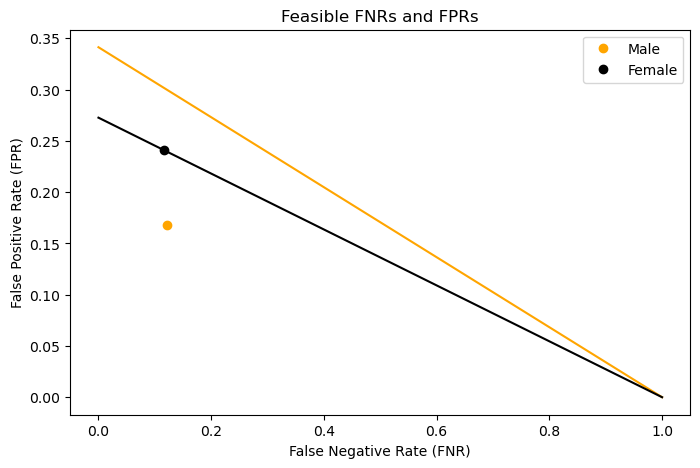

In [ ]:
from matplotlib import pyplot as plt

prevalence = df_test_RF.groupby("group")["label"].mean()
p_male = prevalence.loc[1]
p_female = prevalence.loc[2]

# Recalculating FNR here to make continuity more clear/avoid using variables from other cells

# Calculate true positives and false positives by group
df_test_RF["true_positive"] = (df_test_RF["predicted_value"] == 1) & (df_test_RF["label"] == 1)
df_test_RF["false_positive"] = (df_test_RF["predicted_value"] == 1) & (df_test_RF["label"] == 0)
df_test_RF["false_negative"] = (df_test_RF["predicted_value"] == 0) & (df_test_RF["label"] == 1)
df_test_RF["true_negative"] = (df_test_RF["predicted_value"] == 0) & (df_test_RF["label"] == 0)

# Calculate PPV by group
TP_per_group_RF = df_test_RF.groupby("group")["true_positive"].sum()
FP_per_group_RF = df_test_RF.groupby("group")["false_positive"].sum()
FN_per_group_RF = df_test_RF.groupby("group")["false_negative"].sum()
TN_per_group_RF = df_test_RF.groupby("group")["true_negative"].sum()

PPV_per_group = TP_per_group_RF / (TP_per_group_RF + FP_per_group_RF)
PPV_male = PPV_per_group.loc[1]
PPV_female = PPV_per_group.loc[2]

# Calculate FNR
FNR = FN_per_group_RF / (FN_per_group_RF + TP_per_group_RF)
FNR_male = FNR.loc[1]
FNR_female = FNR.loc[2]

# Calculate FPR
FPR_male = (p_male / (1 - p_male)) * ((1 - PPV_male) / PPV_male) * (1 - FNR_male)
FPR_female = (p_female / (1 - p_female)) * ((1 - PPV_female) / PPV_female) * (1 - FNR_female)

feasible_FNR_range = np.linspace(0, 1, 100)

FPR_male_line = (p_male / (1 - p_male)) * ((1 - PPV_female) / PPV_female) * (1 - feasible_FNR_range)
FPR_female_line = (p_female / (1 - p_female)) * ((1 - PPV_female) / PPV_female) * (1 - feasible_FNR_range)

plt.figure(figsize=(8, 5))

plt.plot(FNR_male, FPR_male, 'o', color='orange', label='Male')
plt.plot(FNR_female, FPR_female, 'o', color='black', label='Female')

plt.plot(feasible_FNR_range, FPR_male_line, '-', color='orange')
plt.plot(feasible_FNR_range, FPR_female_line, '-', color='black')

plt.xlabel("False Negative Rate (FNR)")
plt.ylabel("False Positive Rate (FPR)")
plt.title("Feasible FNRs and FPRs")
plt.legend()


**Tuning the classifier threshold**: Looking at the feasibility curves for males and females, if we set the threshold so that both groups have an FPR of 0.15, the male curve corresponds to an FNR of 0.25, while the female curve corresponds to an FNR of 0.40. Thus, to achieve the same FPR across groups, we must allow the female group’s FNR to increase from 0.25 to 0.40, a difference of 15%.

## Concluding Discussion:

*What groups of people could stand to benefit?*

This model predicts whether an individual is employed, so it could benefit recruiting agencies or HR departments seeking to identify jobseekers or allocate training resources - specifically understanding what feature groups may be searching for a job/have more possible unemployed candidates available to interview.

*Impact of deploying model?*

From the bias audit, we see differences in false positive and false negative rates across groups. If deployed widely, these disparities could systematically disadvantage certain populations—for instance, if a higher false negative rate leads to fewer recognized as “employed,” those individuals might miss job opportunities or loans. Conversely, higher false positives could unfairly label individuals as employed when they are not, whereas false negatives could mean that hiring/search resources are allocated to the wrong demographic areas, disadvantaging those who don't fit the template of an employed/unemployed individual. Even more, the differences in the bias audit reveal the way in which employment data is a proxy for historical prejudice - and in my case, specifically gender-based hiring prejudice - which could lead to reinforced stereotypes of who is "employable" and who is not. 

*Does the Model Display Bias?*

From the bias audit (examining accuracy, PPV, FNR, and FPR by group), we see that the model’s performance differs between males and females for several fairness criterion. For example, it appears that none of the models are well-calibrated as across all we see the positive prediction rate of male employment is several percentage points higher than female employment. More specifically, the PPV ranges from anywhere between ~8%-9% across all of the models. There is also error rate imbalance: the False Positive Rate (FPR) is higher for females across all four, whereas the False Negative Rate (FNR) is higher for males across all four models. Even further, the margin of difference between groups for FPR is much greater than that for FNR across all Models. The FPR difference between groups is at its lowest ~4.56% in our LR model, whereas the largest difference in FNRs is ~1.36%, also found in our LR model. This could lead to prejudicial assumptions which have harmful effects on fair hiring practices. For instance, if one group has a statistically higher false negative rate, that group may be systematically overlooked for certain opportunities.

*Further Concerns?*

The model analyzed here is quite complex. Specifically, it involves the correlation/scoring of a large set of features, and classifier/modeling methods that are not very accessible. In other words, it isn't a very transparent model, and that can lead to a lot of mistrust about how the decisions are being made and why. I also want to know more about *where* the data is being collected in a state, what areas/communities it is taken from, and how representative or random are those samples. To address these issues, we could continue ollect more diverse data, and promote education and transparency initiatives about Machine Learning. Furthermore, it is always important to include human oversight as a "second set of eyes" in decisions made about another person's life from data.